# Variability analysis for HBEC IFN experiment

In [24]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

In [25]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [26]:
data_path = '/data_volume/ifn_hbec/'

In [262]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Get canonical TFs

In [27]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

### Read the processed RNA data

Focus on the club and bc/club cells and type I interferons for now.

Encode the timestamps to integers.

In [5]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_counts.h5ad')

In [6]:
adata = adata[:, ~adata.var.index.str.startswith('MT-')].copy()
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'basal/club' else 'bc')
adata.obs['cell_type'] = adata.obs['cell_type'].apply(lambda x: x if x != 'ionocyte/tuft' else 'ion-tuft')

In [7]:
adata.shape

(69252, 36588)

### Read 1d HT result comparing to control

In [174]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [175]:
def read_result(ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps: 
            adata_subset = sc.read('/data_volume/ifn_hbec/binary_test_deep/{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp))
            ht_dict[stim][tp] = memento.get_1d_ht_result(adata_subset)
            ht_dict[stim][tp]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['de_pval'])
            ht_dict[stim][tp]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['dv_pval'])
            moments_dict[stim][tp] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [176]:
all_result = {}
for ct in cts:
    
    key = '-'.join(ct)
    all_result[key] = {}
    
    all_result[key]['ht'], all_result[key]['moments'] = read_result(ct)

### Some basic enrichment analysis - increased variance

In [11]:
stim = 'gamma'
gene_list = []
for tp in tps[1:]:
    df = all_result['bc-basal']['ht'][stim][tp].query('dv_coef > 0 & dv_fdr < 0.1 & de_coef > 0')
    gene_list += df.gene.tolist()
gene_list = list(set(gene_list))

### Setup memento

In [12]:
def assign_q(batch):
    
    if batch == 0:
        return 0.387*0.25
    elif batch == 1:
        return 0.392*0.25
    elif batch == 2:
        return 0.436*0.25
    else:
        return 0.417*0.25

In [13]:
adata.obs['q'] = adata.obs['batch'].apply(assign_q)

In [14]:
memento.setup_memento(adata, q_column='q')

### Pick top regulators

In [15]:
expr_df = pd.DataFrame()
expr_df['gene'] = adata.var.index.tolist()
expr_df['expr'] = adata.uns['memento']['all_1d_moments'][0]
filtered_tfs = expr_df.query('gene in @tfs').sort_values('expr', ascending=False).head(70).gene.tolist()

### Compute correlations with canonical TFs

In [16]:
cts = [['ciliated'], ['bc', 'basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma']

In [207]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.9)
            

            relevant_tfs = list(set(filtered_tfs) & set(adata_stim.var.index))
            
            memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, adata_stim.var.index)))

            moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            
            wired_df = moment_df.query('time_step_0 > 0.4 | time_step_1 > 0.4', engine='python')
            
            wired_df.to_csv('/data_volume/ifn_hbec/corr_var/moments_{}_{}_{}_sig.csv'.format('-'.join(ct), stim, tp), index=False)

starting ['ciliated'] 3 alpha
starting ['ciliated'] 3 beta
starting ['ciliated'] 3 gamma
starting ['ciliated'] 6 alpha
starting ['ciliated'] 6 beta
starting ['ciliated'] 6 gamma
starting ['ciliated'] 9 alpha
starting ['ciliated'] 9 beta
starting ['ciliated'] 9 gamma
starting ['ciliated'] 24 alpha
starting ['ciliated'] 24 beta
starting ['ciliated'] 24 gamma
starting ['ciliated'] 48 alpha
starting ['ciliated'] 48 beta
starting ['ciliated'] 48 gamma
starting ['bc', 'basal'] 3 alpha
starting ['bc', 'basal'] 3 beta
starting ['bc', 'basal'] 3 gamma
starting ['bc', 'basal'] 6 alpha
starting ['bc', 'basal'] 6 beta
starting ['bc', 'basal'] 6 gamma
starting ['bc', 'basal'] 9 alpha
starting ['bc', 'basal'] 9 beta
starting ['bc', 'basal'] 9 gamma
starting ['bc', 'basal'] 24 alpha
starting ['bc', 'basal'] 24 beta
starting ['bc', 'basal'] 24 gamma
starting ['bc', 'basal'] 48 alpha
starting ['bc', 'basal'] 48 beta
starting ['bc', 'basal'] 48 gamma


### Get correlated TFs for each gene in each state

In [55]:
tps

['3', '6', '9', '24', '48']

In [166]:
gene

'FABP5'

In [221]:
cts = [['ciliated']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha']

In [250]:
def get_tf_g_vars(stim, ct, logfc=1):
        
    g_var_list = []
    tf_var_list = []
    for tp in ['0','3', '6', '9', '24', '48']:

        ctrl_gene_list = []
        for tp2 in tps[1:]:
            df = all_result['-'.join(ct)]['ht'][stim][tp2].query('de_coef > {} & de_fdr < 0.05'.format(logfc))
            ctrl_gene_list += df.gene.tolist()

        print('starting', ct, tp, stim)

        adata_stim = adata.copy()[
            adata.obs.cell_type.isin(ct) & \
            adata.obs.stim.isin(['control', stim]) & \
            adata.obs.time.isin([tp]), :].copy()
        time_converter={int(tp):1}
        adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

        memento.create_groups(adata_stim, label_columns=['donor', 'time_step'])
        memento.compute_1d_moments(adata_stim, min_perc_group=.8)

        relevant_tfs = list(set(tfs) & set(adata_stim.var.index))
        gene_list = list(set(ctrl_gene_list) & set(adata_stim.var.index))

        memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, gene_list)))

        moment_2d = memento.get_2d_moments(adata_stim, groupby='time_step')
        moment_1d = memento.get_1d_moments(adata_stim, groupby='time_step')[1]

        moment_1d.to_csv('/data_volume/ifn_hbec/corr_var/{}_{}_{}_1d.csv'.format('-'.join(ct), stim, tp), index=False)
        moment_2d.to_csv('/data_volume/ifn_hbec/corr_var/{}_{}_{}_2d.csv'.format('-'.join(ct), stim, tp), index=False)

        high_corr_tfs = moment_2d.query('time_step_1 > 0.3', engine='python').groupby('gene_2').gene_1.apply(list)

        g_var = []
        tf_var = []
        for gene in gene_list:

            if not gene in high_corr_tfs.index:
                continue
            g_var.append(moment_1d.query('gene == "{}"'.format(gene)).values[0, 1])
            ts = high_corr_tfs[gene]
        #     tf_var.append(len(ts))
            tf_var.append(np.mean(moment_1d.query('gene.isin(@ts)', engine='python').values[:, 1]))

        print(stats.pearsonr(g_var, tf_var))

        g_var_list.append(np.array(g_var))
        tf_var_list.append(np.array(tf_var))
        
    return np.concatenate(g_var_list), np.concatenate(tf_var_list)


In [237]:
stats.pearsonr(np.concatenate(g_var_list), np.concatenate(tf_var_list))

(0.301706723173527, 1.498313450719037e-46)

starting ['ciliated'] 0 lambda


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


(0.24601790426695563, 0.0005266879260518222)
starting ['ciliated'] 3 lambda
(0.5601861538561371, 2.7055967186244606e-23)
starting ['ciliated'] 6 lambda
(0.35050667527850043, 2.786530906821842e-09)
starting ['ciliated'] 9 lambda
(0.5038161111749582, 9.451739529902435e-20)
starting ['ciliated'] 24 lambda
(0.3309451661002549, 7.695458027398264e-09)
starting ['ciliated'] 48 lambda
(0.43562797929280206, 3.283121296511646e-14)


Text(0, 0.5, 'TF variability')

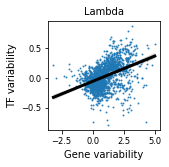

In [263]:
plt.figure(figsize=(2, 2))
g, t = get_tf_g_vars('lambda', ['ciliated'], logfc=0.5)
sns.regplot(g,t,scatter_kws={'s':1}, line_kws={'color':'black', 'lw':3})
plt.title('Lambda'); plt.xlabel('Gene variability'); plt.ylabel('TF variability')

starting ['ciliated'] 0 beta


/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg/memento/main.py:578: RuntimeWarning: invalid value encountered in true_divide
  groupby_corr[key] /= groupby_corr_count[key]


(0.23614357666475178, 0.0008889713169407867)
starting ['ciliated'] 3 beta
(0.5472137572036109, 2.549786869607689e-21)
starting ['ciliated'] 6 beta
(0.5689432220328171, 2.1854773819407643e-24)
starting ['ciliated'] 9 beta
(0.28289091279349843, 2.8786589825749483e-06)
starting ['ciliated'] 24 beta
(0.20708275469411536, 0.000677753515502516)
starting ['ciliated'] 48 beta
(0.11966364633223706, 0.05079946998705278)


Text(0, 0.5, 'TF variability')

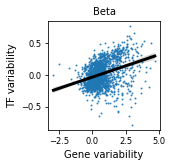

In [264]:
plt.figure(figsize=(2, 2))
g, t = get_tf_g_vars('beta', ['ciliated'], logfc=1)
sns.regplot(g,t,scatter_kws={'s':1}, line_kws={'color':'black', 'lw':3})
plt.title('Beta'); plt.xlabel('Gene variability'); plt.ylabel('TF variability')

### Get correlations for dec and inc var genes

In [244]:
import os
done_files = os.listdir('/data_volume/ifn_hbec/dcoex_test_deep/')

In [253]:
len(filtered_tfs)

1099

In [285]:
for ct in cts:
    for tp in tps:
        for stim in stims:
            
#             ctrl_gene_list = []
#             for tp2 in tps[1:]:
#                 df = all_result['-'.join(ct)]['ht'][stim][tp2].query('~(dv_coef < 0 & dv_fdr < 0.1) & de_coef > 0 & de_fdr < 0.05')
#                 ctrl_gene_list += df.gene.tolist()
            ctrl_gene_list = all_result['-'.join(ct)]['ht'][stim][tp].query('~(dv_coef < 0 & dv_fdr < 0.1) & de_coef > 0 & de_fdr < 0.05').gene.tolist()
            
#             decv_gene_list = []
#             for tp2 in tps[1:]:
#                 df = all_result['-'.join(ct)]['ht'][stim][tp2].query('(dv_coef < 0 & dv_fdr < 0.1) & de_coef > 0 & de_fdr < 0.05')
#                 decv_gene_list += df.gene.tolist()
            decv_gene_list = all_result['-'.join(ct)]['ht'][stim][tp2].query('(dv_coef < 0 & dv_fdr < 0.1) & de_coef > 0 & de_fdr < 0.05').gene.tolist()
            
            
#             fname = '{}_{}_{}_decv.h5ad'.format('-'.join(ct), stim, tp)
#             if fname in done_files:
#                 print('skipping', ct, tp, stim)
#                 continue
                            
            print('starting', ct, tp, stim)

            adata_stim = adata.copy()[
                adata.obs.cell_type.isin(ct) & \
                adata.obs.stim.isin(['control', stim]) & \
                adata.obs.time.isin(['0',tp]), :].copy()
            time_converter={0:0, int(tp):1}
            adata_stim.obs['time_step'] = adata_stim.obs['time'].astype(int).apply(lambda x: time_converter[x])

            memento.create_groups(adata_stim, label_columns=['time_step', 'donor'])
            memento.compute_1d_moments(adata_stim, min_perc_group=.8)

            relevant_tfs = list(set(filtered_tfs) & set(adata_stim.var.index))
            filtered_ctrl_gene_list = list(set(ctrl_gene_list) & set(adata_stim.var.index))
            filtered_decv_gene_list = list(set(decv_gene_list) & set(adata_stim.var.index))
            
            memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, filtered_decv_gene_list)))
            decv_moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            decv_moment_df['diff'] = decv_moment_df['time_step_1'] - decv_moment_df['time_step_0']
            decv_moment_df['type'] = 'dec. var.'
            decv_moment_df['stim'] = stim
            decv_moment_df['tp'] = tp
            decv_moment_df.to_csv('/data_volume/ifn_hbec/corr_var_decv/moments_{}_{}_{}_decv.csv'.format('-'.join(ct), stim, tp), index=False)

            memento.compute_2d_moments(adata_stim, list(itertools.product(relevant_tfs, filtered_ctrl_gene_list)))
            ctrl_moment_df = memento.get_2d_moments(adata_stim, groupby='time_step')
            ctrl_moment_df['diff'] = ctrl_moment_df['time_step_1'] - ctrl_moment_df['time_step_0']
            ctrl_moment_df['type'] = 'rest'
            ctrl_moment_df['stim'] = stim
            ctrl_moment_df['tp'] = tp
            ctrl_moment_df.to_csv('/data_volume/ifn_hbec/corr_var_decv/moments_{}_{}_{}_ctrl.csv'.format('-'.join(ct), stim, tp), index=False)


starting ['ciliated'] 3 alpha
starting ['ciliated'] 3 beta
starting ['ciliated'] 3 gamma
starting ['ciliated'] 6 alpha
starting ['ciliated'] 6 beta
starting ['ciliated'] 6 gamma
starting ['ciliated'] 9 alpha
starting ['ciliated'] 9 beta
starting ['ciliated'] 9 gamma
starting ['ciliated'] 24 alpha
starting ['ciliated'] 24 beta
starting ['ciliated'] 24 gamma
starting ['ciliated'] 48 alpha
starting ['ciliated'] 48 beta
starting ['ciliated'] 48 gamma
starting ['bc', 'basal'] 3 alpha
starting ['bc', 'basal'] 3 beta
starting ['bc', 'basal'] 3 gamma
starting ['bc', 'basal'] 6 alpha
starting ['bc', 'basal'] 6 beta
starting ['bc', 'basal'] 6 gamma
starting ['bc', 'basal'] 9 alpha
starting ['bc', 'basal'] 9 beta
starting ['bc', 'basal'] 9 gamma
starting ['bc', 'basal'] 24 alpha
starting ['bc', 'basal'] 24 beta
starting ['bc', 'basal'] 24 gamma
starting ['bc', 'basal'] 48 alpha
starting ['bc', 'basal'] 48 beta
starting ['bc', 'basal'] 48 gamma


In [17]:
ct = ['ciliated']
stim = 'beta'
all_dfs = []

for tp in tps:
    
    decv_moment_df = pd.read_csv('/data_volume/ifn_hbec/corr_var_decv/moments_{}_{}_{}_decv.csv'.format('-'.join(ct), stim, tp))
    ctrl_moment_df = pd.read_csv('/data_volume/ifn_hbec/corr_var_decv/moments_{}_{}_{}_ctrl.csv'.format('-'.join(ct), stim, tp))
    
    all_dfs.append(decv_moment_df)
    all_dfs.append(ctrl_moment_df)

merged_df = pd.concat(all_dfs, sort=False)

Text(0.5, 0, 'time point (hr)')

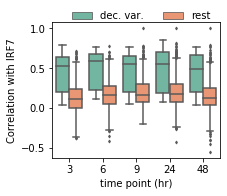

In [18]:
tf = 'IRF7'

dat = merged_df.query('gene_1 == "{}"'.format(tf))
plt.figure(figsize=(3,2.5))
sns.boxplot(x='tp', y='time_step_1', hue='type', data=dat, palette='Set2', fliersize=2);
plt.legend(frameon=False, ncol=2, bbox_to_anchor=(1,1.15))
plt.ylabel('Correlation with {}'.format(tf)); plt.xlabel('time point (hr)')

Text(0.5, 0, 'time point (hr)')

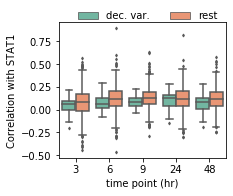

In [22]:
tf = 'STAT1'

dat = merged_df.query('gene_1 == "{}"'.format(tf))
plt.figure(figsize=(3,2.5))
sns.boxplot(x='tp', y='diff', hue='type', data=dat, palette='Set2', fliersize=2);
plt.legend(frameon=False, ncol=2, bbox_to_anchor=(1,1.15))
plt.ylabel('Correlation with {}'.format(tf)); plt.xlabel('time point (hr)')

Text(0.5, 0, 'time point (hr)')

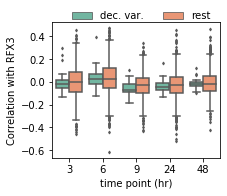

In [23]:
tf = 'RFX3'
plt.figure(figsize=(3,2.5))

sns.boxplot(x='tp', y='diff', hue='type', data=merged_df.query('gene_1 == "{}"'.format(tf)), palette='Set2', fliersize=2);
plt.legend(frameon=False, ncol=2, bbox_to_anchor=(1,1.15))
plt.ylabel('Correlation with {}'.format(tf)); plt.xlabel('time point (hr)')

Text(0.5, 0, 'time point (hr)')

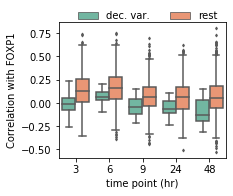

In [67]:
tf = 'FOXP1'
plt.figure(figsize=(3,2.5))

sns.boxplot(x='tp', y='time_step_1', hue='type', data=merged_df.query('gene_1 == "{}"'.format(tf)), palette='Set2', fliersize=2);
plt.legend(frameon=False, ncol=2, bbox_to_anchor=(1,1.15))
plt.ylabel('Correlation with {}'.format(tf)); plt.xlabel('time point (hr)')

In [30]:
for tp in ['3']:
    
    decv_moment_df = pd.read_csv('/data_volume/ifn_hbec/corr_var_decv/moments_{}_{}_{}_decv.csv'.format('-'.join(ct), stim, tp))
    ctrl_moment_df = pd.read_csv('/data_volume/ifn_hbec/corr_var_decv/moments_{}_{}_{}_ctrl.csv'.format('-'.join(ct), stim, tp))
    
    all_dfs.append(decv_moment_df)
    all_dfs.append(ctrl_moment_df)

merged_df = pd.concat(all_dfs, sort=False)

In [32]:
for tf in decv_moment_df.gene_1.drop_duplicates():
    print(tf, '------')
    print('ctrl',ctrl_moment_df.query('gene_1 == "{}"'.format(tf)).time_step_1.mean())
    print('decv',decv_moment_df.query('gene_1 == "{}"'.format(tf)).time_step_1.mean())

PURA ------
ctrl 0.12350764599246863
decv 0.06851004488428007
SOX2 ------
ctrl 0.05453773205805805
decv 0.08542377553536293
NR2F6 ------
ctrl 0.09989842490428608
decv 0.12067598526239562
STAT2 ------
ctrl 0.13025570029066977
decv 0.09232949458074446
IKZF2 ------
ctrl 0.10714211356234743
decv 0.10627884550412028
JUND ------
ctrl 0.09502420433976273
decv 0.18501940918253984
BHLHE40 ------
ctrl 0.10658363020030884
decv 0.35805531174015254
ELF1 ------
ctrl 0.12159485355195704
decv 0.11296318156866228
STAT3 ------
ctrl 0.08134807589823734
decv 0.0808745638394622
KLF5 ------
ctrl 0.14505024015335966
decv 0.29813725254390283
ARID5B ------
ctrl 0.07187196661152621
decv 0.2337520137198537
RFX3 ------
ctrl 0.14839672624711658
decv -0.010840142330837705
ELF3 ------
ctrl 0.17229202000869653
decv 0.18025700280640763
ZKSCAN1 ------
ctrl 0.13409641934203895
decv 0.06632104532257048
IRF2 ------
ctrl 0.04281059970395576
decv 0.00027610582707843776
TCF4 ------
ctrl 0.10255450383231483
decv 0.13140077961

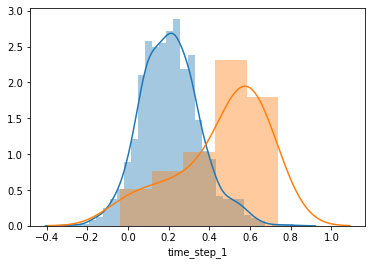

In [272]:
sns.distplot(ctrl_moment_df.query('gene_1 == "STAT1"').time_step_1)
sns.distplot(decv_moment_df.query('gene_1 == "STAT1"').time_step_1)

### Get the correlations

In [107]:
stim = 'gamma'
ct = ['bc-basal']

In [129]:
fname = '/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_incv.csv'.format('-'.join(ct), stim, tp)
tp = '3'
combined_incv = pd.read_csv(fname).rename(columns={'time_step_0':'control', 'time_step_1':('tp'+tp)})[['gene_1', 'gene_2','control', 'tp3']]
for tp in tps[1:]:
    fname = '/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_incv.csv'.format('-'.join(ct), stim, tp)
    df = pd.read_csv(fname).rename(columns={'time_step_0':'control', 'time_step_1':('tp'+tp)})
    combined_incv = combined_incv.merge(df[['gene_1', 'gene_2', 'tp'+tp]], on=['gene_1', 'gene_2'])

In [138]:
fname = '/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_decv.csv'.format('-'.join(ct), stim, tp)
tp = '3'
combined_decv = pd.read_csv(fname).rename(columns={'time_step_0':'control', 'time_step_1':('tp'+tp)})[['gene_1', 'gene_2','control', 'tp3']]
for tp in tps[1:]:
    fname = '/data_volume/ifn_hbec/coex_test_deep/moments_{}_{}_{}_decv.csv'.format('-'.join(ct), stim, tp)
    df = pd.read_csv(fname).rename(columns={'time_step_0':'control', 'time_step_1':('tp'+tp)})
    combined_decv = combined_decv.merge(df[['gene_1', 'gene_2', 'tp'+tp]], on=['gene_1', 'gene_2'])

In [131]:
dc_tfs = list(set(combined_incv.gene_1.values) & set(combined_decv.gene_1.values))

In [116]:
len(dc_tfs)

17

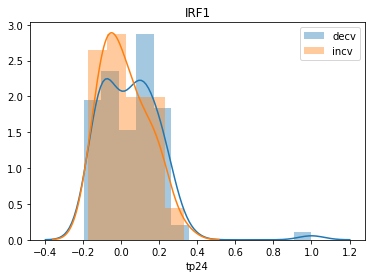

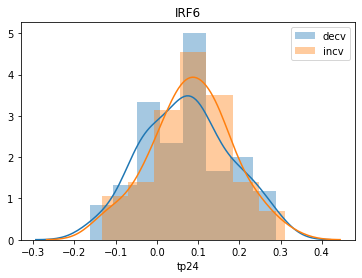

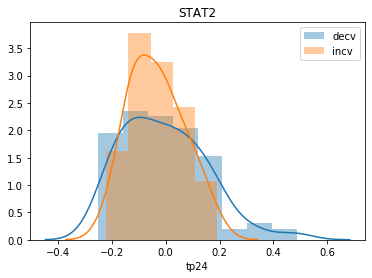

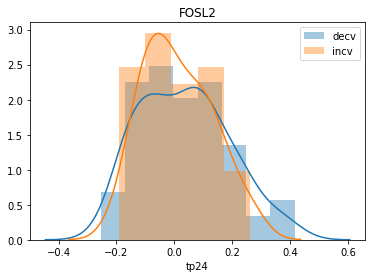

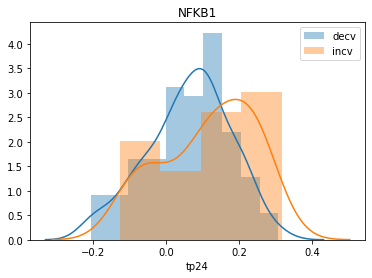

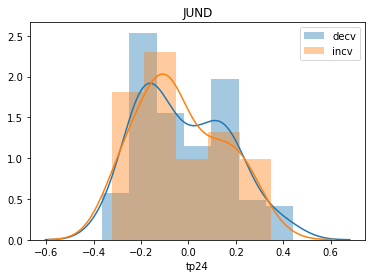

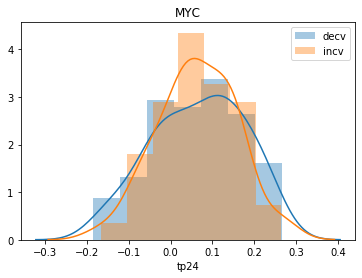

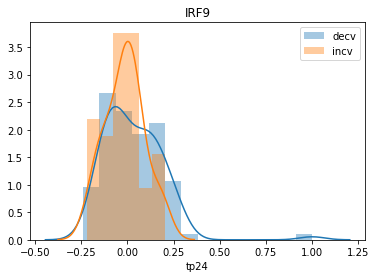

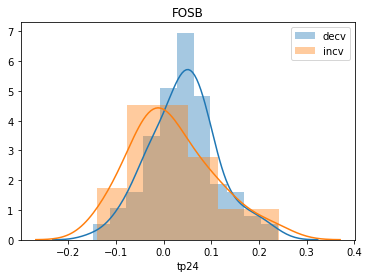

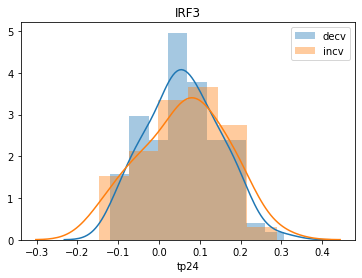

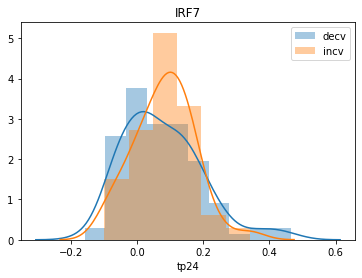

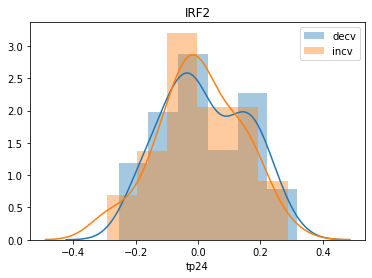

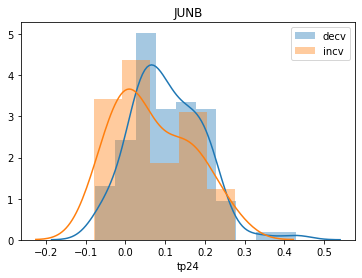

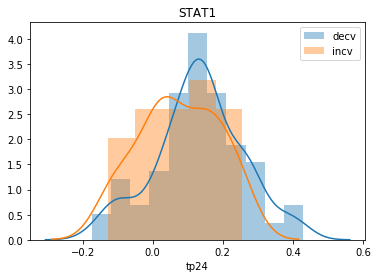

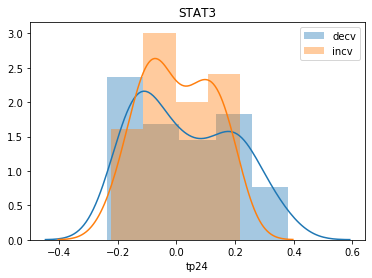

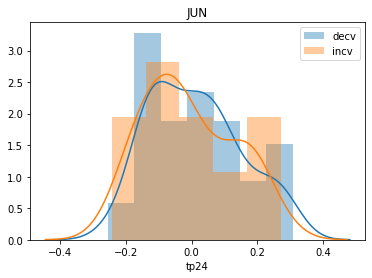

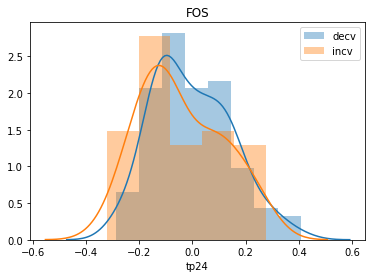

In [151]:
for tf in dc_tfs:
    plt.figure()
#     sns.distplot(combined_decv.query('gene_1 == "{}"'.format(tf)).iloc[:, 3:].values.reshape(-1), label='decv')
#     sns.distplot(combined_incv.query('gene_1 == "{}"'.format(tf)).iloc[:, 3:].values.reshape(-1), label='incv')

    sns.distplot(combined_decv.query('gene_1 == "{}"'.format(tf)).tp24, label='decv')
    sns.distplot(combined_incv.query('gene_1 == "{}"'.format(tf)).tp24, label='incv')
    plt.legend()
    plt.title(tf)


In [103]:
combined_incv

,gene_1,gene_2,control,tp3,tp48
0,IRF1,RPL39,-0.065292,-0.212490,-0.212490
1,IRF1,HLA-DRB1,0.023905,0.107089,0.107089
2,IRF1,IFI44L,0.437770,0.048242,0.048242
3,IRF1,SOCS3,0.085819,0.184960,0.184960
4,IRF1,PLAAT4,0.396816,0.150253,0.150253
...,...,...,...,...,...
1903,FOS,PSMB9,-0.003747,-0.016008,-0.016008
1904,FOS,F3,0.339649,0.197978,0.197978
1905,FOS,FGFBP1,-0.180859,-0.152833,-0.152833
1906,FOS,TXN,0.208298,0.097376,0.097376


### Analyze the 2D information - inc var

In [60]:
tp = '9'
stim = 'gamma'
ct = ['bc-basal']

In [71]:
fname = '/data_volume/ifn_hbec/coex_test_deep/{}_{}_{}_incv.h5ad'.format('-'.join(ct), stim, tp)

In [72]:
a = sc.read(fname)

In [73]:
df = memento.get_2d_ht_result(a)
df = df[~df['gene_2'].str.startswith('RP')].copy()
df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])

In [77]:
df.query('corr_fdr < 0.1 & corr_coef > 0').sort_values('corr_coef', ascending=False)

,gene_1,gene_2,corr_coef,corr_se,corr_pval,corr_fdr
391,IRF9,C4orf3,0.637691,0.213881,0.002800,0.070248
550,IRF7,CXCL10,0.591846,0.178180,0.001042,0.068837
324,MYC,PDLIM4,0.414590,0.139667,0.002600,0.070248
598,JUNB,SLC2A1,0.382446,0.091964,0.001081,0.068837
627,JUNB,HSP90AB1,0.294077,0.070590,0.000758,0.062725
640,JUNB,ENO1,0.269102,0.079693,0.001837,0.070248
638,JUNB,TXNDC17,0.265410,0.063775,0.000646,0.059454
633,JUNB,GAPDH,0.265254,0.054053,0.000482,0.057199
632,JUNB,MIF,0.256217,0.053341,0.002160,0.070248
622,JUNB,EIF4A1,0.233304,0.079349,0.004200,0.089001


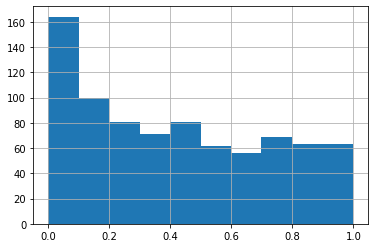

In [33]:
df.corr_pval.hist()